In [1]:
import matplotlib. pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
sys.path.append("..")
import tools
import evals
%matplotlib inline

In [2]:
dataset = "/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/val.tfrecord"
dataset_metadata = "/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/val_index.csv"
batch_size=128

In [3]:
dataset_test = tf.data.TFRecordDataset([dataset])
tfrecord_shape = tools.model.get_shape_of_quadratic_image_tfrecord(dataset_test)
dataset_test = dataset_test.interleave(lambda x: tf.data.Dataset.from_tensors(
tools.model.parse_function(img_shape=tfrecord_shape, test=False)(x)),
                                       num_parallel_calls=tf.data.experimental.AUTOTUNE)
inputs1, truths = tools.data.create_XY_pairs (dataset)
metadata = pd.read_csv(dataset_metadata)

In [4]:
from collections import deque
def FDS(img, roots, pixel_gap, visited_pixels=None):
    if visited_pixels is None:
        visited_pixels = np.zeros(img.shape, dtype=bool)
    height, width = img.shape
    todo = deque([(roots[0], roots[1])])
    mask = np.zeros((height, width), dtype=bool)

    while todo:
        j, i = todo.pop()
        if not visited_pixels[j, i] and img[j, i] != 0:
            visited_pixels[j, i] = True
            img[j, i] = False
            mask[j, i] = True
            j_min = max(j - pixel_gap, 0)
            j_max = min(j + pixel_gap + 1, height)
            i_min = max(i - pixel_gap, 0)
            i_max = min(i + pixel_gap + 1, width)
            for jj in range(j_min, j_max):
                for ii in range(i_min, i_max):
                    if not visited_pixels[jj, ii]:
                        todo.append((jj, ii))

    return mask, visited_pixels

def get_one_image_asteroid_positions(image, pixel_gap=5):
    image = image != 0
    roots_list = []
    roots_list = []
    visited = None
    while image.sum() != 0:
        roots = np.where(image != 0)
        __, visited = FDS(image, (roots[0][0], roots[1][0]), pixel_gap, visited_pixels=visited)
        roots_list.append((roots[0][0], roots[1][0]))
    return roots_list

def read_one_image_asteroids_information(image_index, metadata):
    visit = np.sort(np.unique(metadata["n"].to_numpy()))[image_index]
    return metadata[metadata["n"]==visit]

In [5]:
def plot_detector (calexp, mask):
    fig, ax = plt.subplots(1, 2, figsize=(calexp.shape[0]//200, calexp.shape[1]//100))
    ax[0].imshow(calexp, cmap='gray')
    ax[1].imshow(mask, cmap='gray')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    fig.tight_layout() 
    return fig, ax

def plot_asteroids_cutout (calexp, mask, asteroids_information):
    size = 20
    fig, ax = plt.subplots(len(asteroids_information), 2, figsize=(5*5, 5*len(asteroids_information)))
    for k in range(len(asteroids_information)):
        ast_y = asteroids_information.iloc[k]["x"]
        ast_x = asteroids_information.iloc[k]["y"]
        ax[k, 0].imshow(calexp[ast_x-size:ast_x+size, ast_y-size:ast_y+size], vmin=calexp.min(), 
                        vmax=calexp.max(), cmap='gray')
        ax[k, 1].imshow(mask[ast_x-size:ast_x+size,  ast_y-size:ast_y+size], cmap='gray')
        ax[k, 0].set_xticks([])
        ax[k, 0].set_yticks([])
        ax[k, 1].set_xticks([])
        ax[k, 1].set_yticks([])
        pd.plotting.table(ax[k,1], asteroids_information.iloc[k], loc="left")
    fig.tight_layout()
    return fig, ax

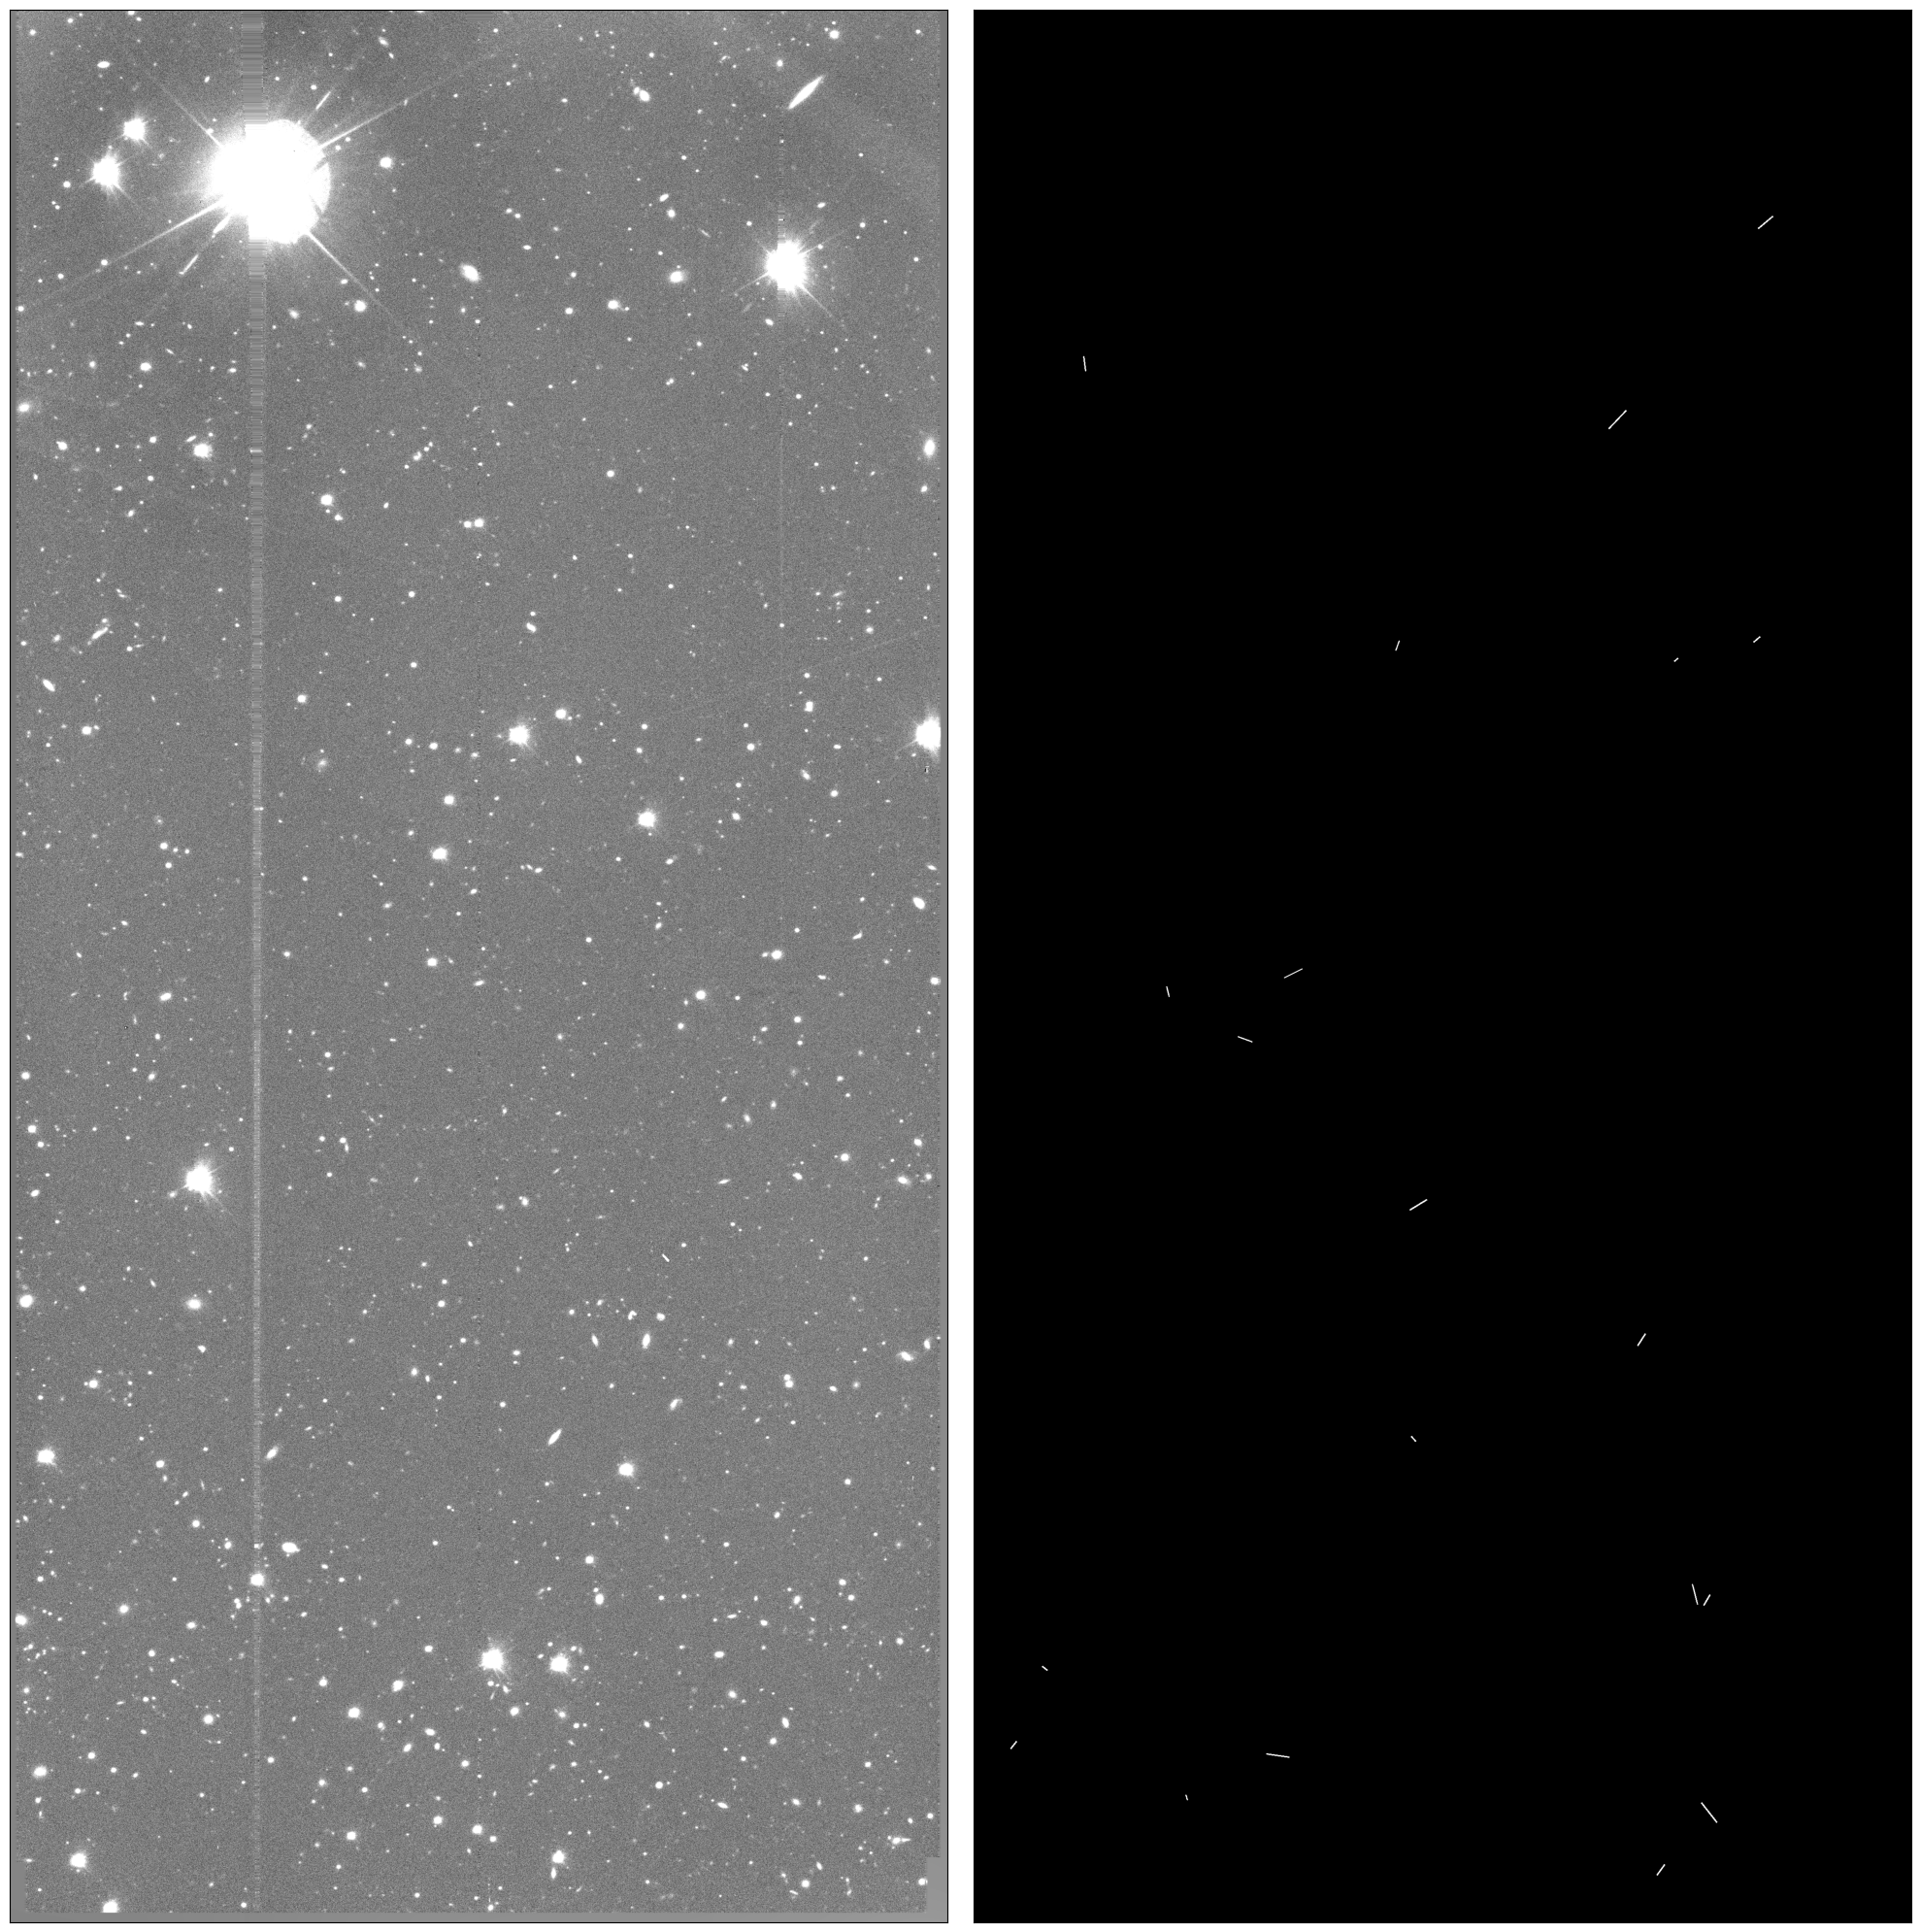

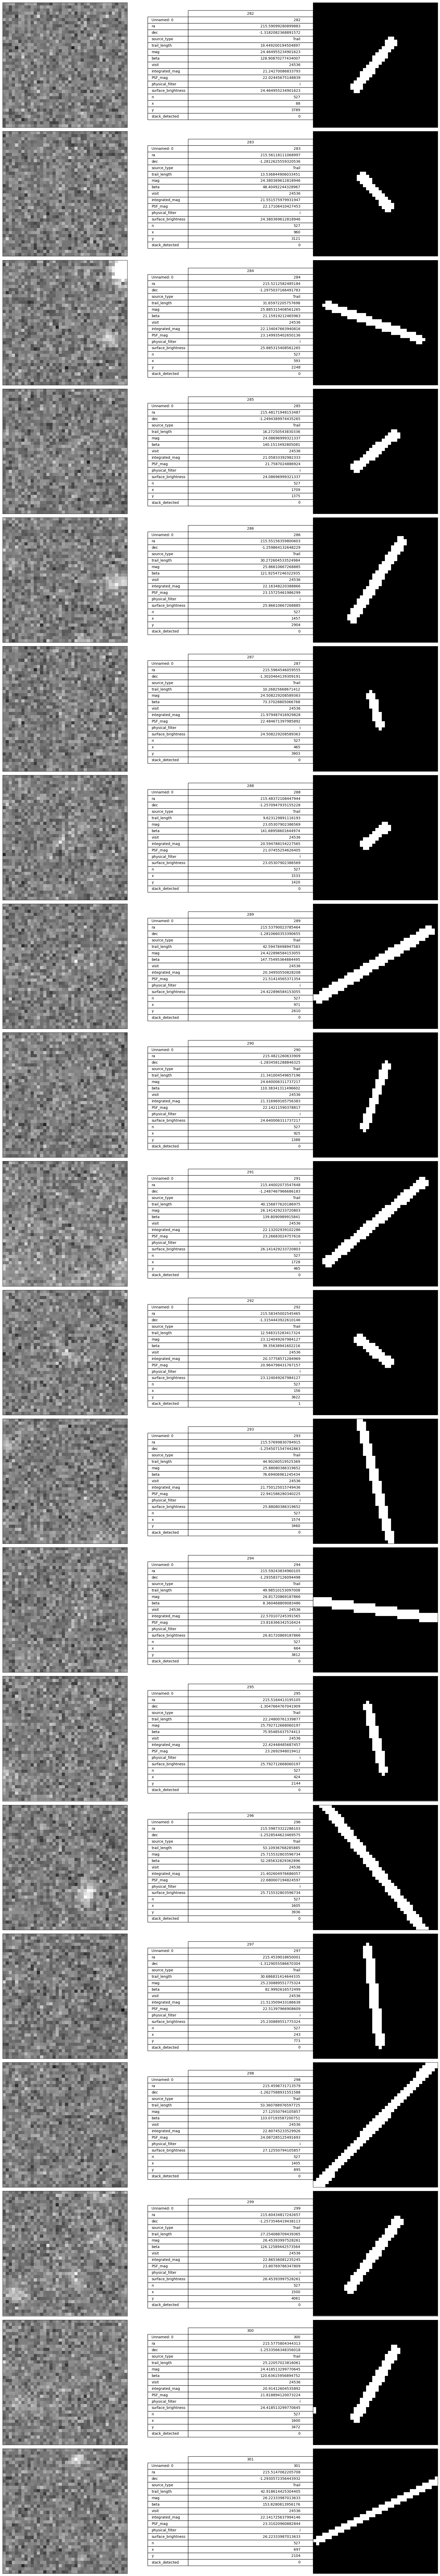

In [6]:
i=3
fig, ax = plot_detector (inputs1[i], truths[i])
fig.savefig('~/panel.png')
asteroids_information = read_one_image_asteroids_information(i, metadata)
fig, ax = plot_asteroids_cutout(inputs1[i], truths[i], asteroids_information)
fig.savefig('~/panel_cutout.png')